In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from zipfile import ZipFile
import os, glob
import cv2
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from tensorflow.keras. layers import Conv2D, Flatten,Dense,MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow. keras.preprocessing. image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow. keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Flatten,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    Activation,
)

2024-10-23 20:02:37.408749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 20:02:37.575592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 20:02:37.591774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 20:02:37.630004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 20:02:39.458667: W tensorflow/compiler/tf2

<hr style="border: 2px solid #fb04ff; width: 80%;">
<h1 style="text-align:center; font-family: 'Arial', sans-serif; color:#fb04ff;">
    🧠 Load and Process the Dataset 📊
</h1>
<hr style="border: 2px solid #fb04ff; width: 80%;">



In [6]:
train_path = r'/home/saher/Projects/Emotion/facial experssion/train'
test_path = r'/home/saher/Projects/Emotion/facial experssion/test'

In [9]:
# remove any identifier files from the subfolders in the train folder
def remove_identifier_files(train_path):
    # Iterate through subfolders in the train directory
    for subfolder in os.listdir(train_path):
        subfolder_path = os.path.join(train_path, subfolder)
        
        # Check if it is a directory
        if os.path.isdir(subfolder_path):
            # Iterate through files in the subfolder
            for file_name in os.listdir(subfolder_path):
                # Check if the file ends with .identifier
                if file_name.endswith('*.identifier'):
                    # Construct the full file path
                    file_path = os.path.join(subfolder_path, file_name)
                    # Remove the file
                    os.remove(file_path)
                    print(f"Removed: {file_path}")
                    
                    
remove_identifier_files(train_path)
remove_identifier_files(test_path)

In [10]:
print('Number of images in each subfolder of the train folder')
for expression in os.listdir(train_path):
    print(str(len(os.listdir(train_path + "/" + expression))) + " " + expression + " images")
print("-"*60) 
print('Total number of images in the train folder:', sum([len(files) for r, d, files in os.walk(train_path)]))
print("-"*60)

print('Number of images in each subfolder of the val folder')
for expression in os.listdir(test_path):
    print(str(len(os.listdir(test_path + "/" + expression))) + " " + expression + " images")
print("-"*60) 
print('Total number of images in the val folder:', sum([len(files) for r, d, files in os.walk(test_path)]))
print("-"*60)

Number of images in each subfolder of the train folder
6342 surprise images
9660 sad images
14430 happy images
10864 angry images
11266 fear images
9930 neutral images
1255 disgust images
------------------------------------------------------------
Total number of images in the train folder: 63747
------------------------------------------------------------
Number of images in each subfolder of the val folder
1662 surprise images
2494 sad images
3548 happy images
207 angry images
124 fear images
2466 neutral images
358 disgust images
------------------------------------------------------------
Total number of images in the val folder: 10859
------------------------------------------------------------


In [11]:
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1, # 10% random width shift
    height_shift_range = 0.1, # 10% random height shift
    horizontal_flip = True, # Random images flipping along the horizontal axis
    rescale = 1./255,  # scale the images to be between 0 and 1
    validation_split = 0.2 # reserve 20% of the data for validation
)
train_generated = train_datagen.flow_from_directory(
    directory = train_path, 
    target_size = (48, 48), # make all images 48x48 pixels
    batch_size = 64, # number of images per batch
    color_mode = "grayscale", 
    class_mode = "categorical",  
    subset = "training" 
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)
val_generated = validation_datagen.flow_from_directory(
    directory = test_path,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = "grayscale",
    class_mode = "categorical",
    subset = "validation"
)

Found 24663 images belonging to 7 classes.
Found 1082 images belonging to 7 classes.


In [15]:
def load_data(path):
    X = []
    Y = []
    
    # List of emotion categories
    categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    base_path = path
    
    # Iterate over each category and load the images
    for category in categories:
        folder_path = f"{base_path}/{category}/*.jpg"
        for file in tqdm(glob.glob(folder_path), desc=f"Loading {category} images"):
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            img = cv2.resize(img, (48, 48))  # Resize to 48x48
            X.append(img)
            Y.append(category)
    
    # Convert lists to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    # Encode the labels
    le = preprocessing.LabelEncoder()
    Y = le.fit_transform(Y)

    return X, Y, le


X_train, y_train, label = load_data(train_path)
X_test, y_test, _ = load_data(test_path)

Loading angry images:   0%|          | 0/4953 [00:00<?, ?it/s]

Loading surprise images: 100%|██████████| 831/831 [00:00<00:00, 35260.51it/s]


<hr style="border: 2px solid #fb04ff; width: 80%;">
<h1 style="text-align:center; font-family: 'Arial', sans-serif; color:#fb04ff;">
    🧠 Show Images 📊
</h1>
<hr style="border: 2px solid #fb04ff; width: 80%;">



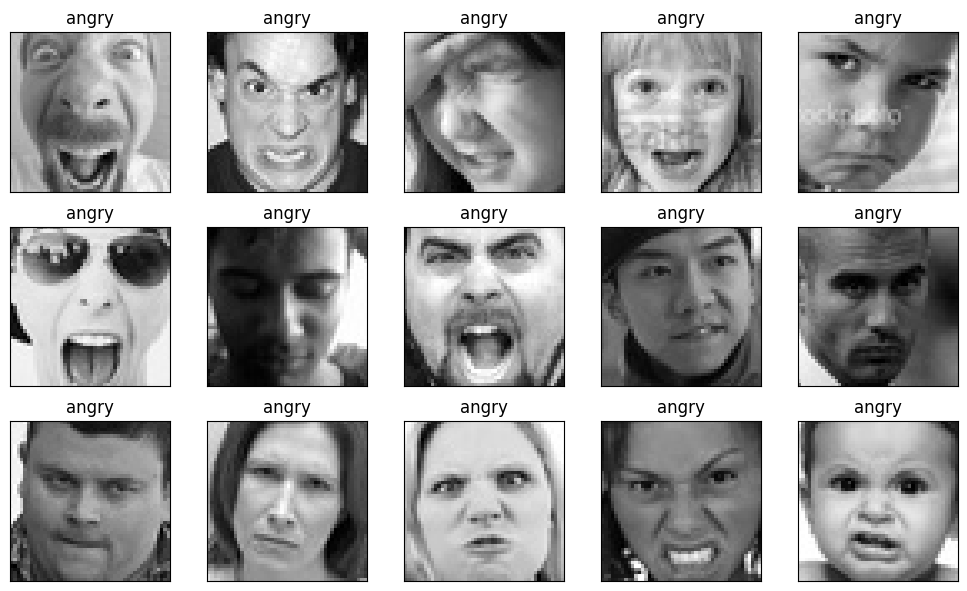

In [18]:
# Display some sample images
plt.figure(figsize=(10, 6))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')  
    plt.title(label.inverse_transform([y_train[i]])[0])  # Show the emotion label
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

<hr style="border: 2px solid #fb04ff; width: 80%;">
<h1 style="text-align:center; font-family: 'Arial', sans-serif; color:#fb04ff;">
    🧠 Build our CNN Model Archeticture📊
</h1>
<hr style="border: 2px solid #fb04ff; width: 80%;">



In [19]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

model = Sequential()

model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# fully connected layers
model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))



model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )
model.summary()

/home/saher/Projects/Anime Vs Cartoon/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1729703106.660027  121775 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729703108.419486  121775 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729703108.419604  121775 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729703108.422637 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,496,903 (17.15 MB)

 Trainable params: 4,492,935 (17.14 MB)

 Non-trainable params: 3,968 (15.50 KB)

<hr style="border: 2px solid #fb04ff; width: 80%;">
<h1 style="text-align:center; font-family: 'Arial', sans-serif; color:#fb04ff;">
    🧠 Fitting our Model 📊
</h1>
<hr style="border: 2px solid #fb04ff; width: 80%;">



In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.weights.h5', # Path to save the model weights
    monitor='val_accuracy',  
    save_best_only=True, # Save only if val_accuracy improves
    save_weights_only=True, # Save only the weights
    mode='max', # Maximize val_accuracy
    verbose=0
)

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, # Number of epochs with no improvement after which training will stop
    restore_best_weights=True, # Restore the model weights from the epoch with the best value of the monitored quantity
    verbose=0
)

# Model fitting
history = model.fit(
    train_generated, # Training data generator
    steps_per_epoch=len(train_generated), # Number of steps per epoch
    epochs=70, # Number of epochs
    validation_data=val_generated, # Validation data generator
    validation_steps=len(val_generated), # Number of validation steps
    callbacks=[checkpoint_callback, early_stopping] # List of callbacks
)

Epoch 1/70


/home/saher/Projects/Anime Vs Cartoon/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729703121.083174  122447 service.cc:146] XLA service 0x7f44ec01b180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729703121.083232  122447 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-10-23 20:05:21.223296: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 20:05:21.812019: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 

386/386 ━━━━━━━━━━━━━━━━━━━━ 53s 97ms/step - accuracy: 0.1756 - loss: 9.6017 - val_accuracy: 0.2458 - val_loss: 8.4474
Epoch 2/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 48us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/70
  1/386 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.2500 - loss: 8.4933

2024-10-23 20:06:10.837287: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-23 20:06:10.837377: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-10-23 20:06:10.846766: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/home/saher/Projects/Anime Vs Cartoon/env/lib/python3.12/site-packages/keras/src/callbacks/model_ch

386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.2121 - loss: 8.4572 - val_accuracy: 0.3475 - val_loss: 7.3644
Epoch 4/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.2118 - loss: 7.6707

2024-10-23 20:06:32.569171: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-23 20:06:32.569246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:06:32.569270: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.2316 - loss: 7.4030 - val_accuracy: 0.3946 - val_loss: 6.2785
Epoch 6/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 21us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.2717 - loss: 6.5423

2024-10-23 20:06:52.194785: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:06:52.194880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.2592 - loss: 6.3671 - val_accuracy: 0.3854 - val_loss: 5.3555
Epoch 8/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.3142 - loss: 5.4991

2024-10-23 20:07:13.668691: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-23 20:07:13.668760: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:07:13.668788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.2851 - loss: 5.4139 - val_accuracy: 0.4270 - val_loss: 4.4875
Epoch 10/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.3134 - loss: 4.8016

2024-10-23 20:07:35.388959: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:07:35.389019: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.3191 - loss: 4.6203 - val_accuracy: 0.4094 - val_loss: 3.9313
Epoch 12/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 21us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.3733 - loss: 4.0148

2024-10-23 20:07:54.758142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187
2024-10-23 20:07:54.758204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:07:54.762721: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:07:54.762782: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.3453 - loss: 3.9641 - val_accuracy: 0.4399 - val_loss: 3.4244
Epoch 14/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 21us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 15/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.3125 - loss: 3.5792

2024-10-23 20:08:16.487243: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851


386/386 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.3613 - loss: 3.4497 - val_accuracy: 0.2366 - val_loss: 3.7238
Epoch 16/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 17/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.4661 - loss: 2.9451

2024-10-23 20:08:35.847655: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187
2024-10-23 20:08:35.852018: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-23 20:08:35.852095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:08:35.852125: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.3917 - loss: 3.0215 - val_accuracy: 0.3974 - val_loss: 2.8723
Epoch 18/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 21us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 19/70
  2/386 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.3361 - loss: 2.8849

2024-10-23 20:08:57.456363: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:08:57.456430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.4153 - loss: 2.6978 - val_accuracy: 0.4861 - val_loss: 2.4266
Epoch 20/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 21/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.4374 - loss: 2.4485 - val_accuracy: 0.4926 - val_loss: 2.2404
Epoch 22/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 23/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.4483 - loss: 2.2470 - val_accuracy: 0.5203 - val_loss: 2.1047
Epoch 24/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 25/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.4444 - loss: 2.1477

2024-10-23 20:10:01.194691: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:10:01.194758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.4720 - loss: 2.1013 - val_accuracy: 0.5619 - val_loss: 1.8999
Epoch 26/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 27/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.4967 - loss: 1.9567 - val_accuracy: 0.6128 - val_loss: 1.6707
Epoch 28/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 29/70
  1/386 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.4531 - loss: 1.8907

2024-10-23 20:10:43.136696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:10:43.136807: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.5003 - loss: 1.8628 - val_accuracy: 0.6340 - val_loss: 1.6201
Epoch 30/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 31/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.5081 - loss: 1.7902 - val_accuracy: 0.6553 - val_loss: 1.5477
Epoch 32/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 33/70
  2/386 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.4609 - loss: 1.8868

2024-10-23 20:11:24.665774: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.5148 - loss: 1.7277 - val_accuracy: 0.5157 - val_loss: 1.8005
Epoch 34/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 35/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.5069 - loss: 1.7580

2024-10-23 20:11:46.381704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:11:46.381767: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.5382 - loss: 1.6539 - val_accuracy: 0.6470 - val_loss: 1.4443
Epoch 36/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 37/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.4939 - loss: 1.6265

2024-10-23 20:12:07.952164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:12:07.952227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.5343 - loss: 1.6282 - val_accuracy: 0.5628 - val_loss: 1.6525
Epoch 38/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 39/70
  2/386 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.5156 - loss: 1.6957 

2024-10-23 20:12:27.217762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:12:27.217842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.5452 - loss: 1.6058 - val_accuracy: 0.5998 - val_loss: 1.5215
Epoch 40/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 41/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.5526 - loss: 1.5727 - val_accuracy: 0.6118 - val_loss: 1.5424
Epoch 42/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 43/70
  2/386 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.5938 - loss: 1.5749

2024-10-23 20:13:08.158127: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:13:08.158191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.5629 - loss: 1.5414 - val_accuracy: 0.6081 - val_loss: 1.5276
Epoch 44/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 45/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.5278 - loss: 1.6336

2024-10-23 20:13:29.720440: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:13:29.720495: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.5691 - loss: 1.5255 - val_accuracy: 0.6728 - val_loss: 1.3846
Epoch 46/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 47/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.5700 - loss: 1.5097 - val_accuracy: 0.5887 - val_loss: 1.5224
Epoch 48/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 49/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.5750 - loss: 1.4954 - val_accuracy: 0.6525 - val_loss: 1.4288
Epoch 50/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 51/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.5816 - loss: 1.4585

2024-10-23 20:14:32.613685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:14:32.613743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.5861 - loss: 1.4742 - val_accuracy: 0.6423 - val_loss: 1.4525
Epoch 52/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 53/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.5243 - loss: 1.4610

2024-10-23 20:14:51.882377: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:14:51.882439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.5857 - loss: 1.4608 - val_accuracy: 0.6590 - val_loss: 1.3979
Epoch 54/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 55/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.6042 - loss: 1.5110

2024-10-23 20:15:13.505250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:15:13.505309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.5924 - loss: 1.4604 - val_accuracy: 0.6590 - val_loss: 1.4383
Epoch 56/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 54us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 57/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.5896 - loss: 1.4447 - val_accuracy: 0.6460 - val_loss: 1.4853
Epoch 58/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 59/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.5868 - loss: 1.4202

2024-10-23 20:15:54.850444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:15:54.850506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.6036 - loss: 1.4280 - val_accuracy: 0.6664 - val_loss: 1.3550
Epoch 60/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 24us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 61/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.6042 - loss: 1.4145

2024-10-23 20:16:16.951667: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851


386/386 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.6034 - loss: 1.4132 - val_accuracy: 0.6765 - val_loss: 1.3276
Epoch 62/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 24us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 63/70
  2/386 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.5469 - loss: 1.4292

2024-10-23 20:16:36.506010: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:16:36.506088: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.6033 - loss: 1.4110 - val_accuracy: 0.6617 - val_loss: 1.4070
Epoch 64/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 65/70
  1/386 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.6250 - loss: 1.4453

2024-10-23 20:16:58.314601: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-23 20:16:58.314692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:16:58.314737: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.6144 - loss: 1.4031 - val_accuracy: 0.6488 - val_loss: 1.4154
Epoch 66/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 67/70
  3/386 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.5885 - loss: 1.4244

2024-10-23 20:17:20.446164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851
2024-10-23 20:17:20.446232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6977884099160478187


386/386 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.6146 - loss: 1.4008 - val_accuracy: 0.6913 - val_loss: 1.3354
Epoch 68/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 69/70
  2/386 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.6094 - loss: 1.5212

2024-10-23 20:17:40.033822: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851


386/386 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.6235 - loss: 1.3890 - val_accuracy: 0.6756 - val_loss: 1.3522
Epoch 70/70
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


2024-10-23 20:18:02.382869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15112293586764056851


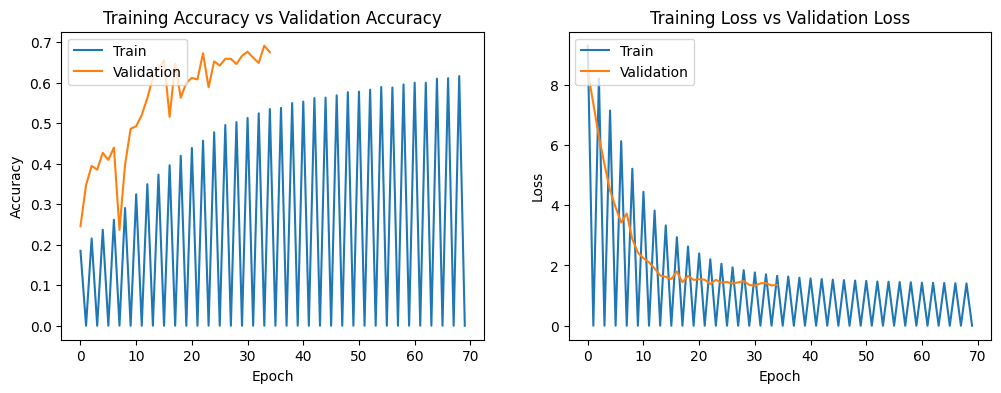

In [21]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

<hr style="border: 2px solid #fb04ff; width: 80%;">
<h1 style="text-align:center; font-family: 'Arial', sans-serif; color:#fb04ff;">
    🧠 Model Validation and Evaluation📊
</h1>
<hr style="border: 2px solid #fb04ff; width: 80%;">



In [25]:
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)
test_generated = test_datagen.flow_from_directory(
    directory = test_path,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = "grayscale",
    class_mode = "categorical",
    subset = "validation"
)

model.evaluate(test_generated) # test accuracy


Found 1082 images belonging to 7 classes.


/home/saher/Projects/Anime Vs Cartoon/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6782 - loss: 1.3718


[1.3354328870773315, 0.6913123726844788]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Predicted emotion: happy


(-0.5, 47.5, 47.5, -0.5)

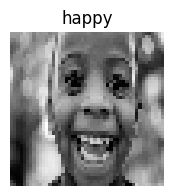

In [34]:
# Model Validation
img = r'/home/saher/Projects/Emotion/happy-face1.jpg'

# Load the image and convert it to grayscale
img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (48, 48))  # Resize to 48x48
img = np.array(img) / 255.0  # Normalize the image
img = np.expand_dims(img, axis=(0, -1))  # Add batch and channel dimensions

# Predict the emotion
predictions = model.predict(img)
emotion = label.inverse_transform([np.argmax(predictions)])[0]
print(f"Predicted emotion: {emotion}")

# Display the image
plt.figure(figsize=(2,2))
plt.imshow(img[0, :, :, 0], cmap='gray')
plt.title(emotion)
plt.axis('off')